In [93]:
import pandas as pd
from datetime import timedelta
import yfinance as yf
import os
import praw
from praw.models import Comment
from dotenv import load_dotenv
from datetime import datetime
import re
import torch
from transformers import DistilBertTokenizer, DistilBertModel, pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

In [94]:
# Range of timeframe
start_date = '2025-03-17'
end_date = '2025-04-17'

# Stock to analyze
# NOTE THAT IT SHOULD BE A STOCK/INDEX FROM US STOCK, otherwise the analysis can make no sense
# ticker = '^VIX' by default
ticker = '^VIX'

# How many days with the biggest change do you want to analyze
# num_of_biggest changes = 3 by default
num_of_biggest_changes = 3

# Number of first x comments sorted by the number of upvote to analyze from thread
# top_x = 50 by default, more is not recommended due to a time efficiency
top_x = 50

# Number of clusters you want the algorithm to create from the given data
# n_clusters = 5 by default
n_clusters = 5

In [95]:
def load_timeframe(start_date, end_date):
    try:
        business_days = pd.date_range(start=start_date, end=end_date, freq='B')
        timeframe = pd.DataFrame({'Date': business_days, 'Open': 0.0, 'Close': 0.0, 'Daily change [%]': 0.0,
                                  'Total change [%]': 0.0})

        return timeframe

    except Exception as e:
        print(f'Error in load_timeframe: {e}')

def load_stock_timeframe(ticker, timeframe):
    for index, row in timeframe.iterrows():
        try:
            date = row['Date']
            data = yf.download(ticker, start=date.strftime('%Y-%m-%d'),
                                   end=(date + timedelta(days=1)).strftime('%Y-%m-%d'), auto_adjust=False)
            open_price = data['Open'].iloc[0] if isinstance(data['Open'].iloc[0], float) else data['Open'].iloc[
                0].item()
            close_price = data['Close'].iloc[0] if isinstance(data['Close'].iloc[0], float) else data['Close'].iloc[
                0].item()

            timeframe.loc[index, 'Open'] = open_price
            timeframe.loc[index, 'Close'] = close_price

        except Exception as e:
            print(f"Error in load_stock_timeframe while retrieving data for {ticker} on {row['Date']}: {e}")
            timeframe.drop(index, inplace=True)
            continue

    timeframe['Daily change [%]'] = (timeframe['Close'] / timeframe['Open'] - 1) * 100
    timeframe['Total change [%]'] = (timeframe['Close'] / timeframe['Close'].iloc[0] - 1) * 100

def biggest_changes(timeframe, num_of_biggest_changes=3):
    if num_of_biggest_changes <= len(timeframe):
        timeframe_copy = timeframe.copy()
        timeframe_sorted = timeframe_copy.reindex(
            timeframe_copy['Daily change [%]'].abs().sort_values(ascending=False).index
        )
        return timeframe_sorted.head(num_of_biggest_changes).reset_index(drop=True)
    else:
        print('num_of_biggest_changes should not be bigger than number of rows in timeframe \n'
              'Change num_of_biggest_changes in controller.py')



In [96]:
load_dotenv()

REDDIT_CLIENT_ID = os.getenv("REDDIT_CLIENT_ID")
REDDIT_CLIENT_SECRET = os.getenv("REDDIT_CLIENT_SECRET")
USER_AGENT = "sentiment-analysis by /u/your_username"

reddit = praw.Reddit(
    client_id=REDDIT_CLIENT_ID,
    client_secret=REDDIT_CLIENT_SECRET,
    user_agent=USER_AGENT
)

def format_date(date_str):
    dt = datetime.strptime(date_str, "%Y-%m-%d")
    return dt.strftime("%B %d, %Y")

def is_valid_comment(text):
    text = text.strip().lower()
    if text.startswith("[deleted") or text.startswith("[ removed"):
        return False
    if re.search(r"http[s]?://|www\.|\.(com|jpg|png|gif)", text, re.IGNORECASE):
        return False
    if re.search(r"!\[.*?\]\(.*?\)", text):
        return False
    return True

def fetch_top_comments_as_dataframe(date_str, top_x=100):
    formatted_date = format_date(date_str)
    expected_title = f"Daily Discussion Thread for {formatted_date}"
    print(f"Searching for thread: {expected_title}...")
    subreddit = reddit.subreddit("wallstreetbets")

    for submission in subreddit.search("Daily Discussion Thread", sort="new", time_filter="all"):
        if expected_title in submission.title:
            print(f"Found: {submission.title}")

            print("Setting comment sort to 'top'...")
            submission.comment_sort = "top"
            submission.comments.replace_more(limit=0)

            comments = submission.comments.list()

            valid_comments = [
                comment for comment in comments
                if isinstance(comment, Comment) and is_valid_comment(comment.body)
            ]

            sorted_comments = sorted(valid_comments, key=lambda c: c.score, reverse=True)
            print(f"Taking top {top_x} valid comments...")

            top_comments_data = []
            for comment in sorted_comments[:top_x]:
                top_comments_data.append({
                    "text": comment.body,
                    "upvotes": max(comment.score, 1)
                })

            df = pd.DataFrame(top_comments_data)
            return df

    raise ValueError(f"Could not find Daily Discussion Thread for {date_str}")

In [97]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

def analyze_sentiment(text):
    result = sentiment_pipeline(text)[0]
    score = result['score']
    return score if result['label'] == 'POSITIVE' else -score

def add_sentiment_column(df):
    df['sentiment'] = df['text'].apply(analyze_sentiment)
    return df

def calculate_weighted_sentiment(df):
    weighted_sum = (df['sentiment'] * df['upvotes']).sum()
    total_upvotes = df['upvotes'].sum()

    if total_upvotes == 0:
        return 0

    weighted_average = weighted_sum / total_upvotes
    return weighted_average

def cluster_pca_kmeans(embeddings, n_clusters=5):
    pca = PCA(n_components=50)
    x_reduced = pca.fit_transform(embeddings)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(x_reduced)

    return clusters

Device set to use cpu


In [98]:
STOPWORDS_CUSTOM = set(STOPWORDS)
for letter in list("abcdefghijklmnopqrstuvwxyz"):
    STOPWORDS_CUSTOM.add(letter)

WORD_REGEX = re.compile(r"\b[a-zA-Z]{2,}\b")

def stock_plot(timeframe, column, ticker):
    try:
        plt.plot(timeframe['Date'], timeframe[f'{column}'], label=f'{column} of {ticker}', linewidth=3, linestyle='--',
                 color='black')
        plt.xlabel('Date')
        plt.ylabel(f'{column}')
        plt.legend()
        plt.grid()
        plt.show()

    except Exception as e:
        print(f"Error in stock_plot: {e}")

def plot_wordcloud(df):
    text_series = df['text'].astype(str).tolist()
    all_text = ' '.join(text_series)
    tokens = WORD_REGEX.findall(all_text)
    combined = ' '.join(tokens)

    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=STOPWORDS_CUSTOM
    ).generate(combined)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def plot_cluster_wordcloud(df):
    for cluster_id in sorted(df['cluster'].unique()):
        texts = df.loc[df['cluster'] == cluster_id, 'text'].astype(str).tolist()
        all_text = ' '.join(texts)
        tokens = WORD_REGEX.findall(all_text)
        combined = ' '.join(tokens)

        wc = WordCloud(
            width=800,
            height=400,
            background_color='white',
            stopwords=STOPWORDS_CUSTOM
        ).generate(combined)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for Cluster {cluster_id}")
        plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

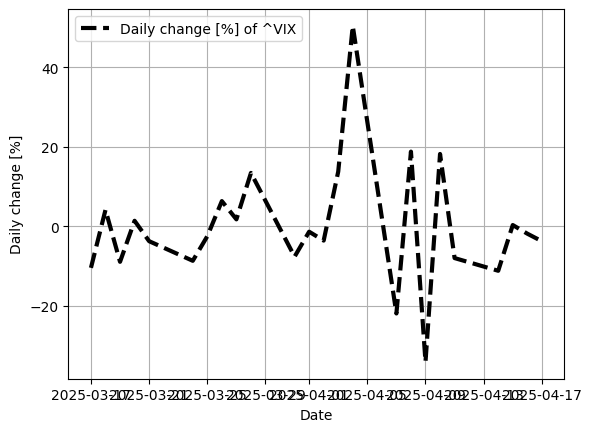

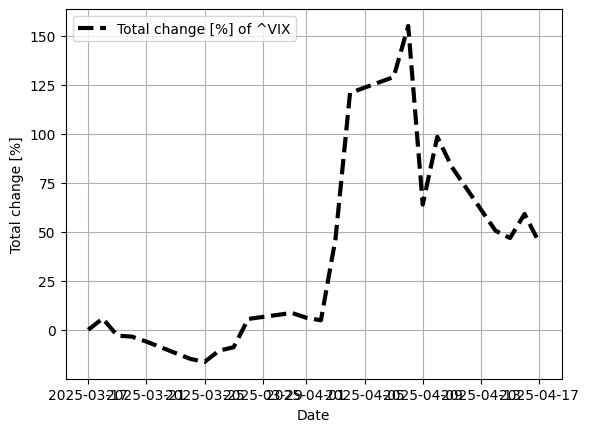

        Date       Open      Close  Daily change [%]  Total change [%]
0 2025-04-04  30.120001  45.310001         50.431607        120.916630
1 2025-04-09  50.980000  33.619999        -34.052571         63.920032
2 2025-04-07  60.130001  46.980000        -21.869285        129.058991
Searching for thread: Daily Discussion Thread for April 04, 2025...
Found: Daily Discussion Thread for April 04, 2025
Setting comment sort to 'top'...
Taking top 50 valid comments...
                                                text  upvotes
0  OPERATION WAS SUCCESSFUL BUT THE PATIENT DIED\...      751
1  They called him sleepy Joe because you could s...      600
2  I moved my entire 401k and ira to money market...      515
3  Looked in at r/conservative yesterday to see h...      481
4  I love how so many economists were like “this ...      479


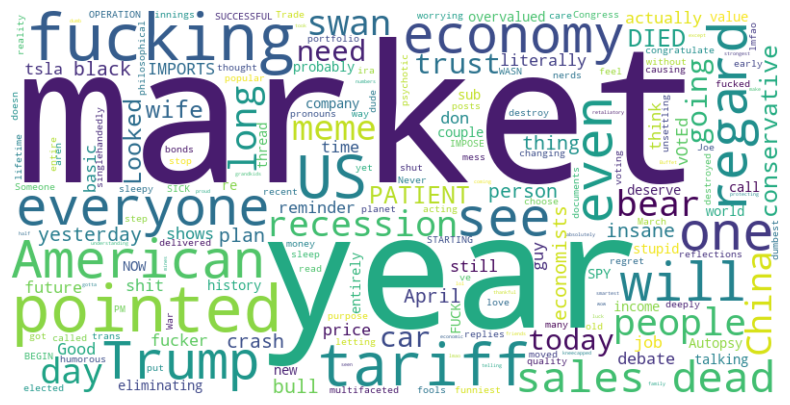

Overall weighted sentiment for the day 2025-04-04: -0.440


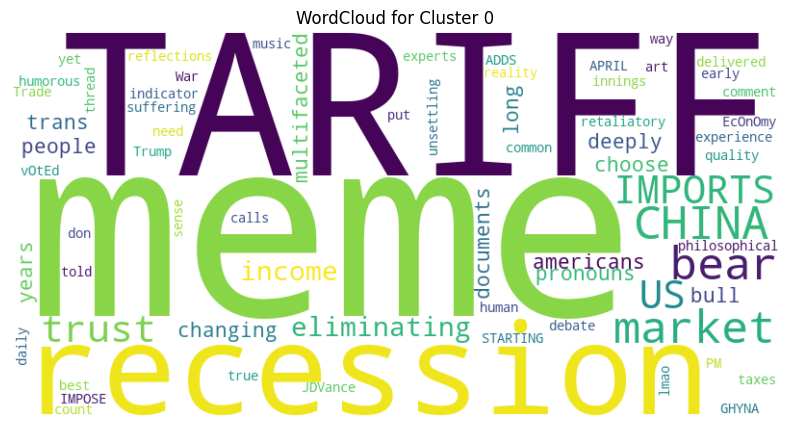

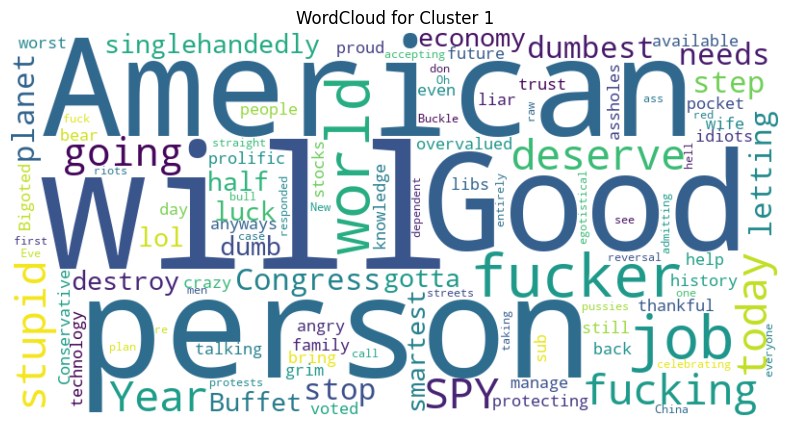

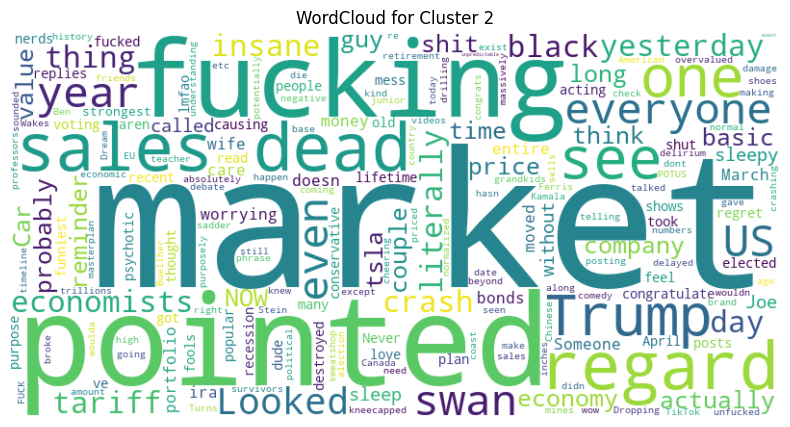

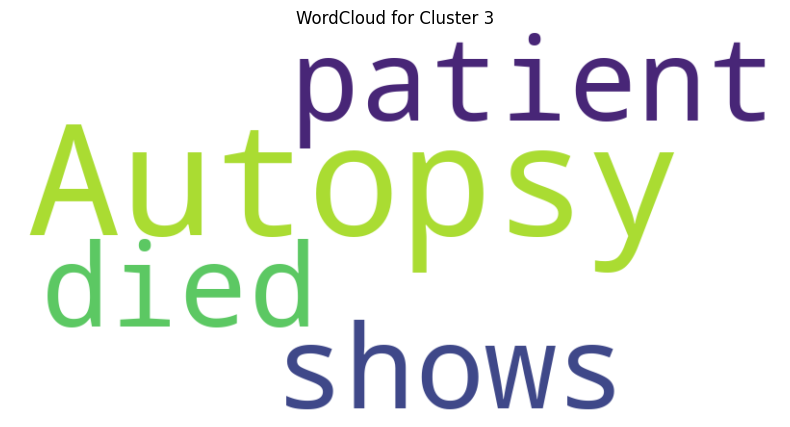

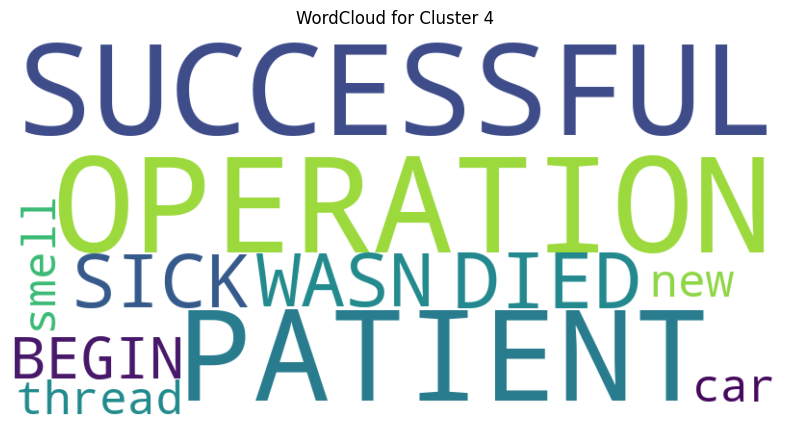

In [99]:
if __name__ == "__main__":
    # pd.set_option('display.max_columns', None)
    # pd.set_option('display.max_rows', None)

    timeframe = load_timeframe(start_date, end_date)
    load_stock_timeframe(ticker, timeframe)

    stock_plot(timeframe, 'Daily change [%]', ticker)
    stock_plot(timeframe, 'Total change [%]', ticker)

    biggest_changes = biggest_changes(timeframe, num_of_biggest_changes)
    print(biggest_changes)
    dates = biggest_changes["Date"].tolist()

    ### main function to analyze all days from biggest_changes
    # for date in dates:
    #     print(f'Analysis for day {date}...')
    #     ...

    ### Debugging with one date
    date = '2025-04-04'
    df = fetch_top_comments_as_dataframe(date, top_x)
    print(df.head())

    df['embedding'] = df['text'].apply(get_embedding)
    df['sentiment'] = df['text'].apply(analyze_sentiment)

    embeddings = df['embedding'].tolist()
    df['cluster'] = cluster_pca_kmeans(embeddings, n_clusters)

    plot_wordcloud(df)
    overall_sentiment = calculate_weighted_sentiment(df)
    print(f"Overall weighted sentiment for the day {date}: {overall_sentiment:.3f}")

    """
        1: POSITIVE sentiment
        0: NEUTRAL sentiment
       -1: NEGATIVE sentiment
    """

    plot_cluster_wordcloud(df)